In [1]:
# imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
#import xesmf as xe
#from scipy import stats
#from xmip.preprocessing import combined_preprocessing
#from xarrayutils.plotting import shaded_line_plot
#from datatree import DataTree
#from xmip.postprocessing import _parse_metric
#import cartopy.crs as ccrs
#import pooch
import os
#import tempfile
import modred as mr
#import pysindy as ps
#from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, Dataset
#from torch.autograd import grad
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchdyn.models import *
from torchdyn.core import NeuralODE
from torchdyn.nn import DataControl, DepthCat, Augmenter, GalLinear, Fourier
from torchdyn.datasets import *
from torchdyn.utils import *

In [4]:
ds = xr.open_dataset('tos_Omon_ensemblemean_historical_r1i1p1f1_190001-201412_actual.nc') # ocean temperature
ds2 = xr.open_dataset('tas_Global_ensemble_historical_r1i1p1f1_mean.nc') # air temperature
ds3 = xr.open_dataset('pr_Global_ensemble_historical_r1i1p1f1_mean.nc') # precipitation
ds4 = xr.open_dataset('sfcWind_Global_ensemble_historical_r1i1p1f1_mean.nc') # wind speed

# we can use air temperature and precipitation datasets as well
sst_clim = ds.tos.sel(time=slice("1900-01-01", "2009-12-01"),lat=slice(-10.5,10.5), lon=slice(180,240)) # for running mean of previous 30 years of climate
sst = ds.tos.sel(time=slice("1930-01-01", "2009-12-01"),lat=slice(-10.5,10.5), lon=slice(180,240)) #
sst_anom = sst # subtract climatology later
wind_clim = ds4.sfcWind.sel(time=slice("1900-01-01", "2009-12-01"))
wind = ds4.sfcWind.sel(time=slice("1930-01-01", "2009-12-01"))
wind_anom = wind # subtract climatology later

# take out annual trends with a 12 month rolling mean
roll = 12
da = sst_anom.sel(lat=slice(-10.5,10.5), lon=slice(180,240)).rolling(time=roll).mean()
da = da[roll-1:,:,:] - sst_clim.rolling(time=12*30).mean()
da4 = wind_anom.sel(lat=slice(-10.5,10.5), lon=slice(180,240)).rolling(time=roll).mean()
da4 = da4[roll-1:,:,:] - wind_clim.rolling(time=12*30).mean()

# convert to array with all grid cells as rows and time as columns
X_to = np.transpose(da.values.reshape(da.values.shape[0],da.values.shape[1]*da.values.shape[2]))
X_wi = np.transpose(da4.values.reshape(da4.values.shape[0],da4.values.shape[1]*da4.values.shape[2]))

# delete non ocean data
i = 0
while i<X_to.shape[0]:
    if np.isnan(X_to[i,0]):
        X_to = np.delete(X_to,i,0)
    else:
        i += 1
i = 0
while i<X_wi.shape[0]:
    if np.isnan(X_wi[i,0]):
        X_wi = np.delete(X_wi,i,0)
    else:
        i += 1
    
# ensure there is no NaN values
print(np.isnan(X_to).sum())
print(np.isnan(X_wi).sum())

0
0


In [5]:
# perform POD to reduce dimensionality of the data
num_modes_to = 1
POD_res_to = mr.compute_POD_arrays_snaps_method(
    X_to, list(mr.range(num_modes_to)))
modes_to = POD_res_to.modes
eigvals_to = POD_res_to.eigvals
proj_coeffs_to = np.transpose(POD_res_to.proj_coeffs[0:num_modes_to,:])

num_modes_wi = 1
POD_res_wi = mr.compute_POD_arrays_snaps_method(
    X_wi, list(mr.range(num_modes_wi)))
modes_wi = POD_res_wi.modes
eigvals_wi = POD_res_wi.eigvals
proj_coeffs_wi = np.transpose(POD_res_wi.proj_coeffs[0:num_modes_wi,:])

In [6]:
roll1 = 12
# wind data is noisy so it needs to be smoothed out (other data preprocessing plans should be considered)
proj_coeffs_to = pd.DataFrame(proj_coeffs_to).rolling(roll1).mean().values
proj_coeffs_wi = pd.DataFrame(proj_coeffs_wi).rolling(roll1).mean().values
proj_coeffs_to = proj_coeffs_to[roll1-1:,:]
proj_coeffs_wi = proj_coeffs_wi[roll1-1:,:]

# normalize data using a standard scaler
ss_to = StandardScaler()
proj_coeffs_to = ss_to.fit_transform(proj_coeffs_to)
ss_wi = StandardScaler()
proj_coeffs_wi = ss_wi.fit_transform(proj_coeffs_wi)

# create a time series of state vectors
X = np.zeros([proj_coeffs_to.shape[0],proj_coeffs_to.shape[1]*4])
X[:,0:proj_coeffs_to.shape[1]] = proj_coeffs_to
X[:,proj_coeffs_to.shape[1]:2*proj_coeffs_to.shape[1]] = proj_coeffs_wi

# convert time into years
def month_to_seconds(month, year):
    oneday = 0.
    if year%4==0:
        oneday = 3600.*24
    if month == 1.:
        return 0.
    elif month == 2.:
        return 31.*3600*24
    elif month == 3.:
        return (31.+28)*3600*24+oneday
    elif month == 4.:
        return (31.+28+31)*3600*24+oneday
    elif month == 5.:
        return (31.+28+31+30)*3600*24+oneday
    elif month == 6.:
        return (31.+28+31+30+31)*3600*24+oneday
    elif month == 7.:
        return (31.+28+31+30+31+30)*3600*24+oneday
    elif month == 8.:
        return (31.+28+31+30+31+30+31)*3600*24+oneday
    elif month == 9.:
        return (31.+28+31+30+31+30+31+31)*3600*24+oneday
    elif month == 10.:
        return (31.+28+31+30+31+30+31+31+30)*3600*24+oneday
    elif month == 11.:
        return (31.+28+31+30+31+30+31+31+30+31)*3600*24+oneday
    elif month == 12.:
        return (31.+28+31+30+31+30+31+31+30+31+30)*3600*24+oneday

def convert_time(date):
    year = float(str(date).split('-')[0])
    month = float(str(date).split('-')[1])
    return (year-1980)*3600*24*365 + month_to_seconds(month, year)

t = np.zeros(X.shape[0])
for i in range(X.shape[0]):
    t[i] = convert_time(da.time.values[i])/(24*3600*365)

# include derivative of projection coefficients in state vector (equivalent to a second order ODE)
X[:,2*proj_coeffs_to.shape[1]:3*proj_coeffs_to.shape[1]] = np.gradient(proj_coeffs_to,t,axis=0)
X[:,3*proj_coeffs_to.shape[1]:4*proj_coeffs_to.shape[1]] = np.gradient(proj_coeffs_wi,t,axis=0)


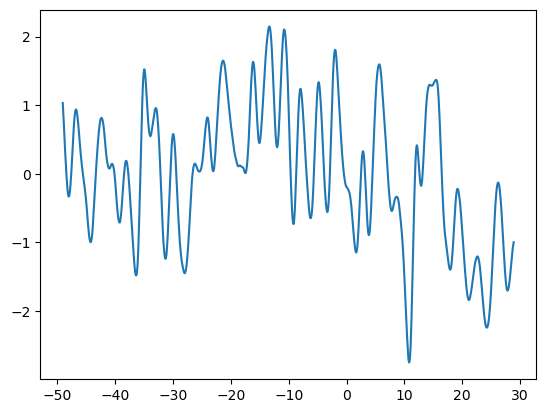

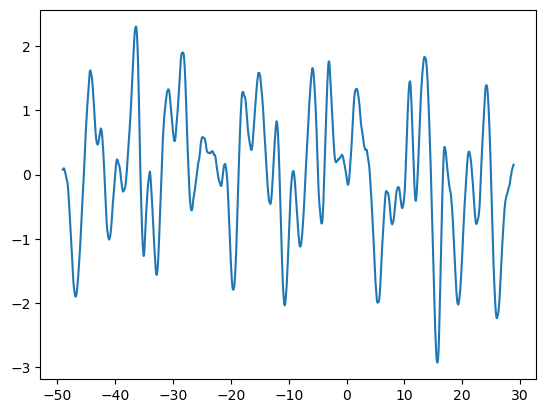

In [7]:
# visualize data

plt.plot(t,proj_coeffs_to[:,0])
plt.show()
plt.plot(t,proj_coeffs_wi[:,0])
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# put data into dataset
class ENSODataset(Dataset):
    
  def __init__(self, X, y):
    if not torch.is_tensor(X) or not torch.is_tensor(y):
      self.X = torch.from_numpy(X).float()
      self.y = torch.from_numpy(y).float() 

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return {"X": self.X[i], "y": self.y[i]}

# select training data
X_train = X[0:X.shape[0]-201,:]
y_train = X[1:-200,:]
train = ENSODataset(X_train, y_train)
trainloader = DataLoader(train, batch_size=128, shuffle=False)

In [9]:
# class to train data
class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx): 
        # x and y batch data
        x = batch["X"]
        y = batch["y"] 
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        print("trainloader")
        return trainloader

In [10]:
# neural network to approximate derivative
f = nn.Sequential(
        nn.Linear(X.shape[1], 64),
        nn.ReLU(), 
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, X.shape[1]))

# data points are approximately 1/12 of a year apart
t_span = torch.linspace(0, 1/12, 2)

# create neural ODE
model = NeuralODE(f, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3).to(device)

# train model
learn = Learner(t_span, model)
trainer = pl.Trainer(min_epochs=200, max_epochs=500)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\dymca\miniconda3\envs\tutorial1\Lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 99.5 K | train
--------------------------------------------
99.5 K    Trainable params
0         Non-trainable params
99.5 K    Total params
0.398     Total estimated model params size (MB)
14        Modules in train mode
0         Modul

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
trainloader


C:\Users\dymca\miniconda3\envs\tutorial1\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\dymca\miniconda3\envs\tutorial1\Lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=500` reached.


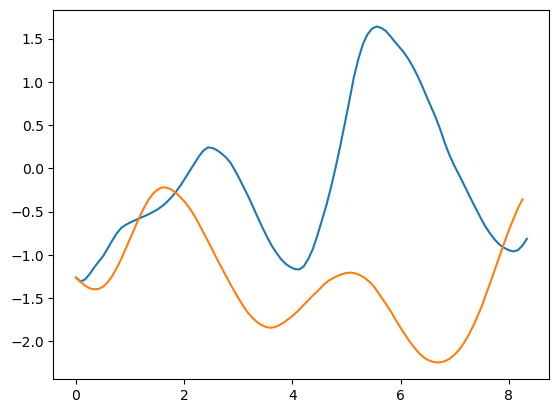

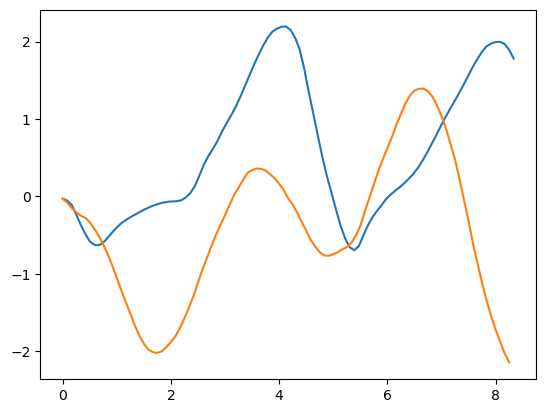

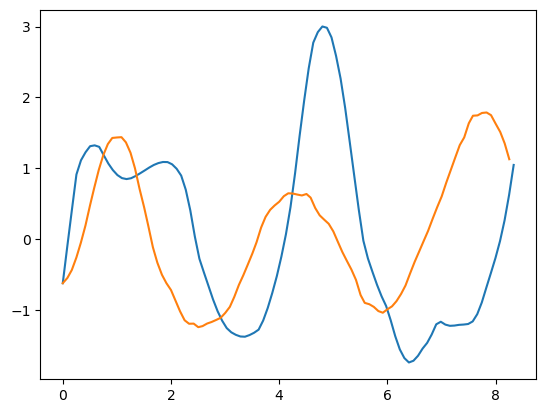

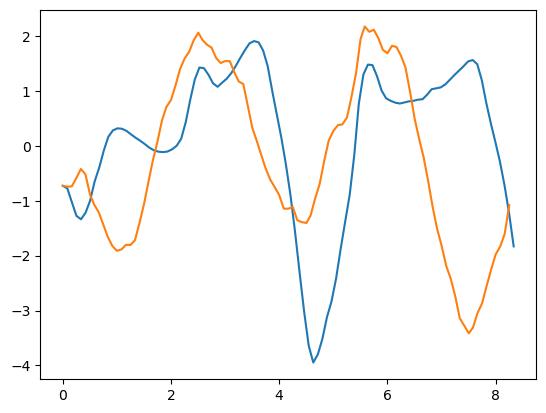

In [33]:
# use model to predict tracjectories
start = 800
t_span = torch.linspace(0,1/12*100,100)
t_eval, trajectory = model(torch.from_numpy(X[start,:]).float().to(device), t_span)
trajectory = trajectory.detach()

plt.plot(t_span,trajectory[:,0])
plt.plot(t[start:start+100]-t[start],X[start:start+100,0])
plt.show()
plt.plot(t_span,trajectory[:,1])
plt.plot(t[start:start+100]-t[start],X[start:start+100,1])
plt.show()
plt.plot(t_span,trajectory[:,2])
plt.plot(t[start:start+100]-t[start],X[start:start+100,2])
plt.show()
plt.plot(t_span,trajectory[:,3])
plt.plot(t[start:start+100]-t[start],X[start:start+100,3])
plt.show()

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# put data into dataset
class ENSO_DDE_Dataset(Dataset):
    
  def __init__(self, X, y):
    if not torch.is_tensor(X) or not torch.is_tensor(y):
      self.X = torch.from_numpy(X).float()
      self.y = torch.from_numpy(y).float() 

  def __len__(self):
      return len(self.X)

  def __getitem__(self, i):
      return {"X": self.X[i], "y": self.y[i]}

seq_size = 4
X_DDE = np.zeros([X.shape[0]-seq_size+1,X.shape[1]*seq_size])
for i in range(X_DDE.shape[0]):
    for j in range(seq_size):
        X_DDE[i,j] = X[i+seq_size-1,j]
        X_DDE[i,j+seq_size] = X[i+seq_size-2,j]
        X_DDE[i,j+2*seq_size] = X[i+seq_size-3,j]
        X_DDE[i,j+3*seq_size] = X[i+seq_size-4,j]

# select training data
X_DDE_train = X_DDE[0:X_DDE.shape[0]-201,:]
y_DDE_train = X_DDE[1:-200,:]
train_DDE = ENSO_DDE_Dataset(X_DDE_train, y_DDE_train)
trainloader_DDE = DataLoader(train_DDE, batch_size=128, shuffle=False)

In [25]:
# class to train data
class Learner_DDE(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx): 
        # x and y batch data
        x = batch["X"]
        y = batch["y"] 
        t_eval, y_hat = self.model(x, self.t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.MSELoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        print("trainloader")
        return trainloader_DDE

In [36]:
# neural network to approximate derivative
f_DDE = nn.Sequential(
        nn.Linear(X_DDE.shape[1], 64),
        nn.ReLU(), 
        nn.Linear(64, 256),
        nn.ReLU(),
        nn.Linear(256, 256),
        nn.ReLU(),
        nn.Linear(256, 64),
        nn.ReLU(),
        nn.Linear(64, X_DDE.shape[1]))

# data points are approximately 1/12 of a year apart
t_span = torch.linspace(0, 1/12, 2)

# create neural ODE
model_DDE = NeuralODE(f_DDE, sensitivity='adjoint', solver='tsit5', interpolator=None, atol=1e-3, rtol=1e-3).to(device)

# train model
learn_DDE = Learner_DDE(t_span, model_DDE)
trainer_DDE = pl.Trainer(min_epochs=300, max_epochs=300)
trainer_DDE.fit(learn_DDE)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | NeuralODE | 101 K  | train
--------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.404     Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
trainloader


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=300` reached.


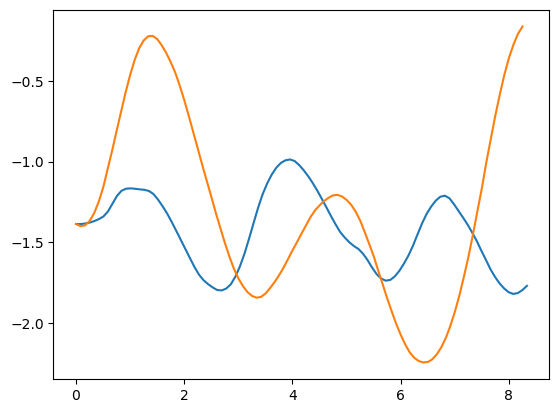

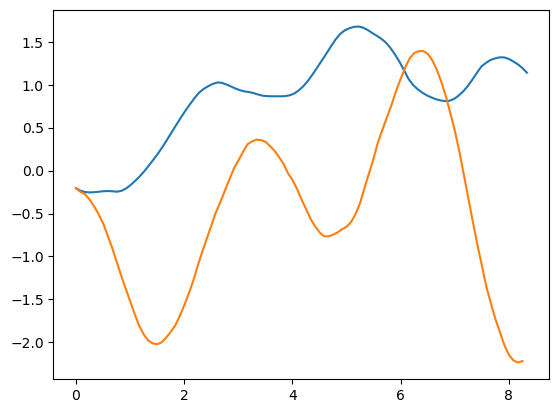

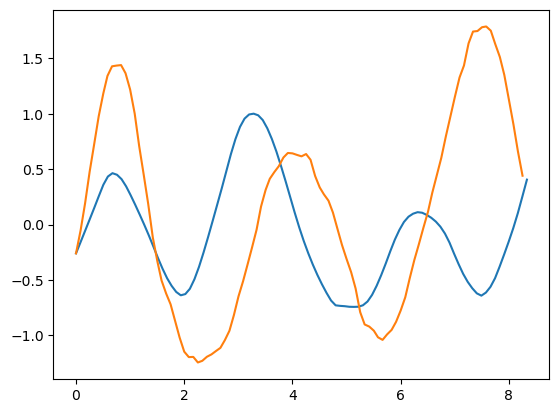

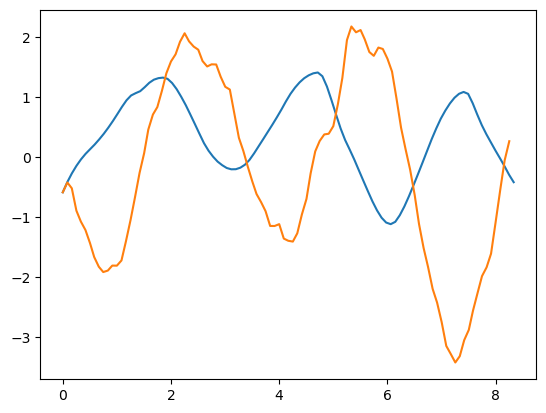

In [39]:
# use model to predict tracjectories
start = 800
t_span = torch.linspace(0,1/12*100,100)
t_eval, trajectory = model_DDE(torch.from_numpy(X_DDE[start,:]).float().to(device), t_span)
trajectory = trajectory.detach()

plt.plot(t_span,trajectory[:,0])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,0])
plt.show()
plt.plot(t_span,trajectory[:,1])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,1])
plt.show()
plt.plot(t_span,trajectory[:,2])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,2])
plt.show()
plt.plot(t_span,trajectory[:,3])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,3])
plt.show()

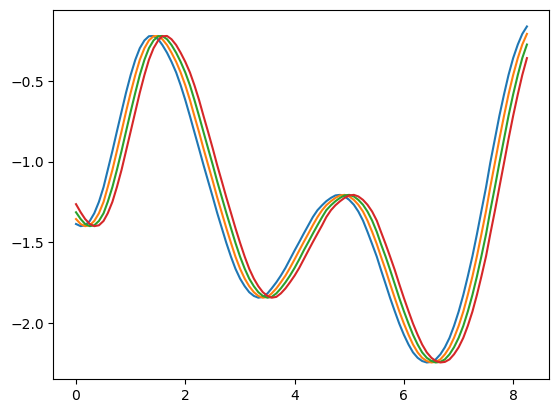

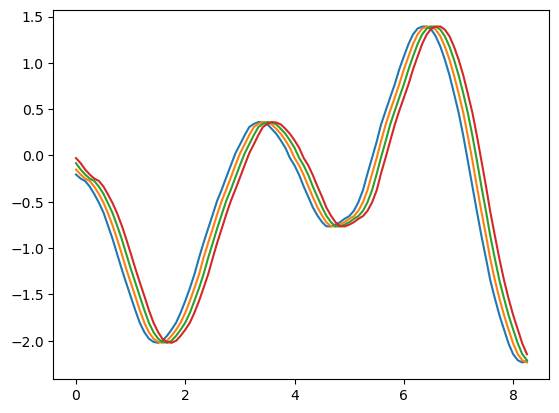

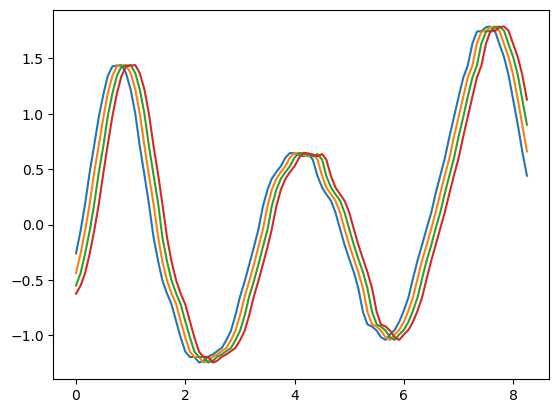

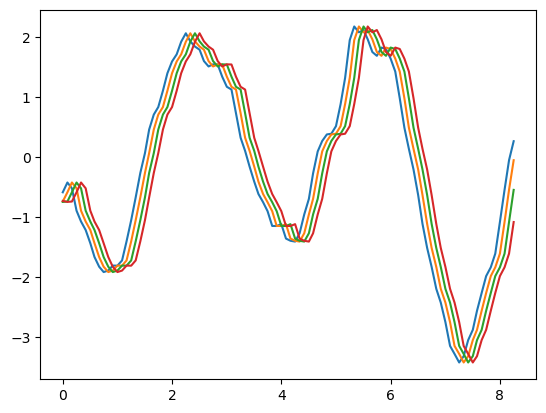

In [40]:
# check to see model functioned as a DDE

plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,0])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,4])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,8])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,12])
plt.show()
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,1])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,5])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,9])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,13])
plt.show()
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,2])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,6])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,10])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,14])
plt.show()
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,3])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,7])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,11])
plt.plot(t[start:start+100]-t[start],X_DDE[start:start+100,15])
plt.show()